## Title Cell

In [3]:
# Import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Import csv, convert to a dataframe. List the columns so we know how to clean it up
diabetes_csv = pd.read_csv("source_data/diabetes_indicators.csv")
diabetes_df = pd.DataFrame(diabetes_csv)
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## William

In [6]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

,Diabetes_012,Income,Education,Age,HvyAlcoholConsump,Fruits,Veggies,CholCheck,HighChol,PhysActivity,BMI
0,0.0,3.0,4.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,40.0
1,0.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,0.0,8.0,4.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,28.0
3,0.0,6.0,3.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,27.0
4,0.0,4.0,5.0,11.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0


In [7]:
# Group by fruit consumption and diabetes status, count the number of participants for each category
dia_fruits = df_trimmed.groupby(["Fruits", "Diabetes_012"]).size().reset_index(name='count')

# ***(I think we could also use a .loc here to make it easier - but this works)***
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
nofruits = dia_fruits[dia_fruits["Fruits"] == 0].copy()
yesfruits = dia_fruits[dia_fruits["Fruits"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
nofruits_sum = nofruits["count"].sum()
nofruits["proportion"] = (nofruits["count"] / nofruits_sum) * 100

yesfruits_sum = yesfruits["count"].sum()
yesfruits["proportion"] = (yesfruits["count"] / yesfruits_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
fruitstack = pd.concat([nofruits, yesfruits], ignore_index=False)
fruitstack

,Fruits,Diabetes_012,count,proportion
0,0.0,0.0,76287,82.221767
1,0.0,1.0,1842,1.985299
2,0.0,2.0,14653,15.792934
3,1.0,0.0,137416,85.405661
4,1.0,1.0,2789,1.733396
5,1.0,2.0,20693,12.860943


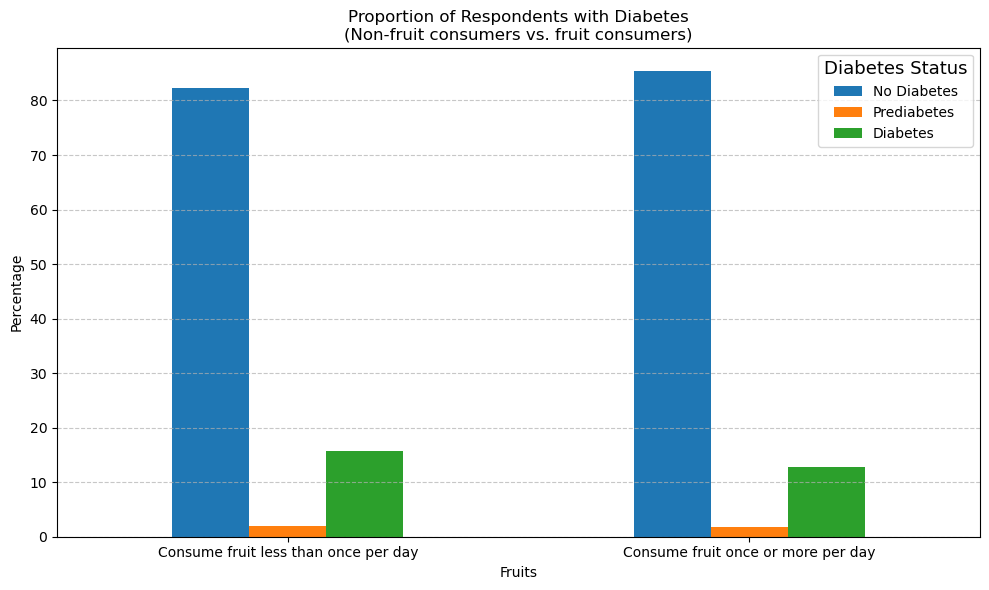

In [8]:
# Set up pivot table to reorganize fruitstack df
pivot_df = fruitstack.pivot(index='Fruits', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume fruit less than once per day', 1.0: 'Consume fruit once or more per day'}
pivot_df.index = pivot_df.index.map(index_mapping)

# Plot the table
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Respondents with Diabetes\n(Non-fruit consumers vs. fruit consumers)')
plt.xlabel('Fruits')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(pivot_df.index)), labels=pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Chinna

In [10]:
# Group by PhysActivity and diabetes status, count the number of participants for each category
dia_PhysActivity = df_trimmed.groupby(["PhysActivity", "Diabetes_012"]).size().reset_index(name='count')

# ***(I think we could also use a .loc here to make it easier - but this works)***
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
no_PhysActivity = dia_PhysActivity[dia_PhysActivity["PhysActivity"] == 0].copy()
yes_PhysActivity = dia_PhysActivity[dia_PhysActivity["PhysActivity"] == 1].copy()

# Find the total respondents per category (PhysActivity and no PhysActivity)
# Create a new column for the proportion of respondents in each row out of their respective category
no_PhysActivity_sum = no_PhysActivity["count"].sum()
no_PhysActivity["proportion"] = (no_PhysActivity["count"] / no_PhysActivity_sum) * 100

yes_PhysActivity_sum = yes_PhysActivity["count"].sum()
yes_PhysActivity["proportion"] = (yes_PhysActivity["count"] / yes_PhysActivity_sum) * 100

# Using the pd.concat() function, combine the two tables into the new PhysActivity df, which shows the proportions
PhysActivitystack = pd.concat([no_PhysActivity, yes_PhysActivity], ignore_index=False)
PhysActivitystack

,PhysActivity,Diabetes_012,count,proportion
0,0.0,0.0,47212,76.444301
1,0.0,1.0,1489,2.410946
2,0.0,2.0,13059,21.144754
3,1.0,0.0,166491,86.750208
4,1.0,1.0,3142,1.637140
5,1.0,2.0,22287,11.612651


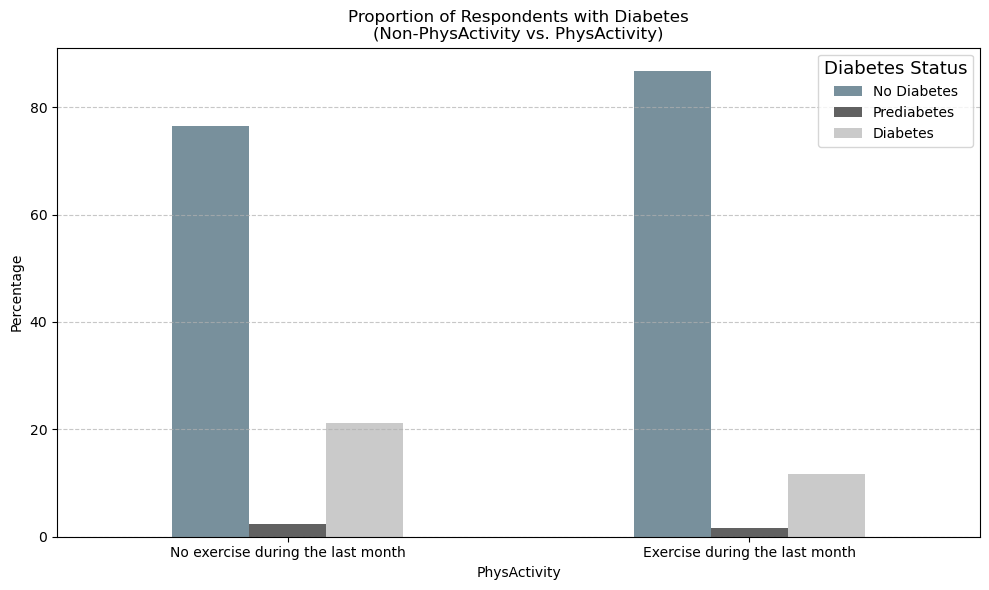

In [11]:
# Set up pivot table to reorganize fruitstack df
PhysActivity_pivot_df = PhysActivitystack.pivot(index='PhysActivity', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
PhysActivity_pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'No exercise during the last month', 1.0: 'Exercise during the last month'}
PhysActivity_pivot_df.index = PhysActivity_pivot_df.index.map(index_mapping)

# Plot the table
colors = ['#78909c','#616161', '#cacaca']
PhysActivity_pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Proportion of Respondents with Diabetes\n(Non-PhysActivity vs. PhysActivity)')
plt.xlabel('PhysActivity')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(PhysActivity_pivot_df.index)), labels=PhysActivity_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

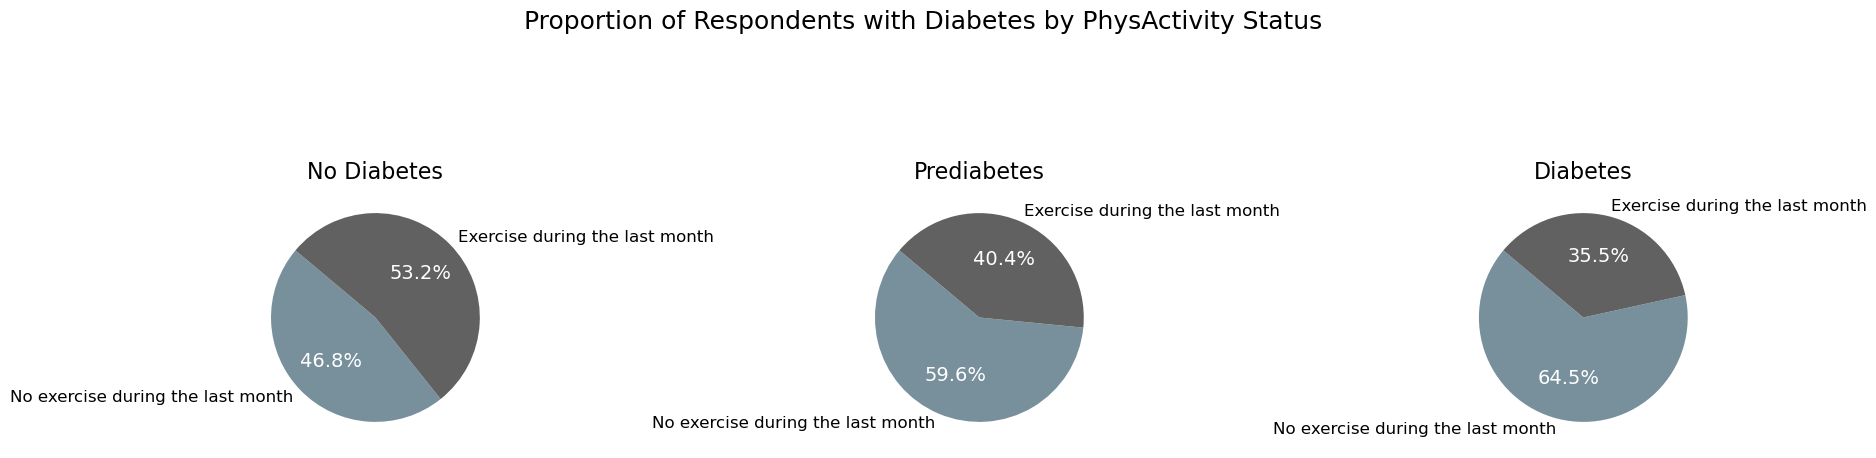

In [48]:
# Example DataFrame setup for demonstration
# Assuming PhysActivity_pivot_df is your DataFrame
# PhysActivity_pivot_df = ...

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define colors
colors = ['#78909c', '#616161', '#cacaca']

for i, column in enumerate(PhysActivity_pivot_df.columns):
    wedges, texts, autotexts = axes[i].pie(
        PhysActivity_pivot_df[column],
        labels=PhysActivity_pivot_df.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors[:len(PhysActivity_pivot_df.index)]  # Adjust colors to match number of slices
    )
    axes[i].set_title(column, fontsize=16, color='black')  # Title font size and color

    # Adjust font size and color for pie chart labels and percentages
    for text in texts:
        text.set_fontsize(12)
        text.set_color('black')  # Set color of pie chart labels
    for autotext in autotexts:
        autotext.set_fontsize(14)
        autotext.set_color('white')  # Set color of percentages

plt.suptitle('Proportion of Respondents with Diabetes by PhysActivity Status', fontsize=18)


plt.tight_layout()
plt.show()


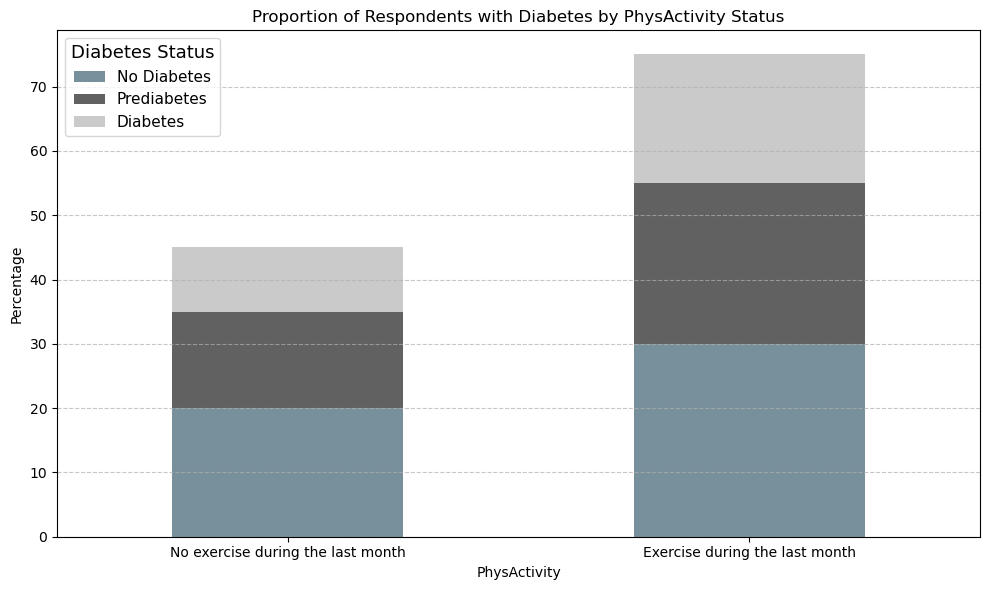

In [53]:
data = {
    'No Diabetes': [20, 30],
    'Prediabetes': [15, 25],
    'Diabetes': [10, 20]
}
PhysActivity_pivot_df = pd.DataFrame(data, index=['No exercise during the last month', 'Exercise during the last month'])

# Define colors for each segment
colors = ['#78909c', '#616161', '#cacaca']

# Plotting the stacked bar chart
ax = PhysActivity_pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Customize the chart
plt.title('Proportion of Respondents with Diabetes by PhysActivity Status')
plt.xlabel('PhysActivity')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(PhysActivity_pivot_df.index)), labels=PhysActivity_pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13', fontsize='11')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

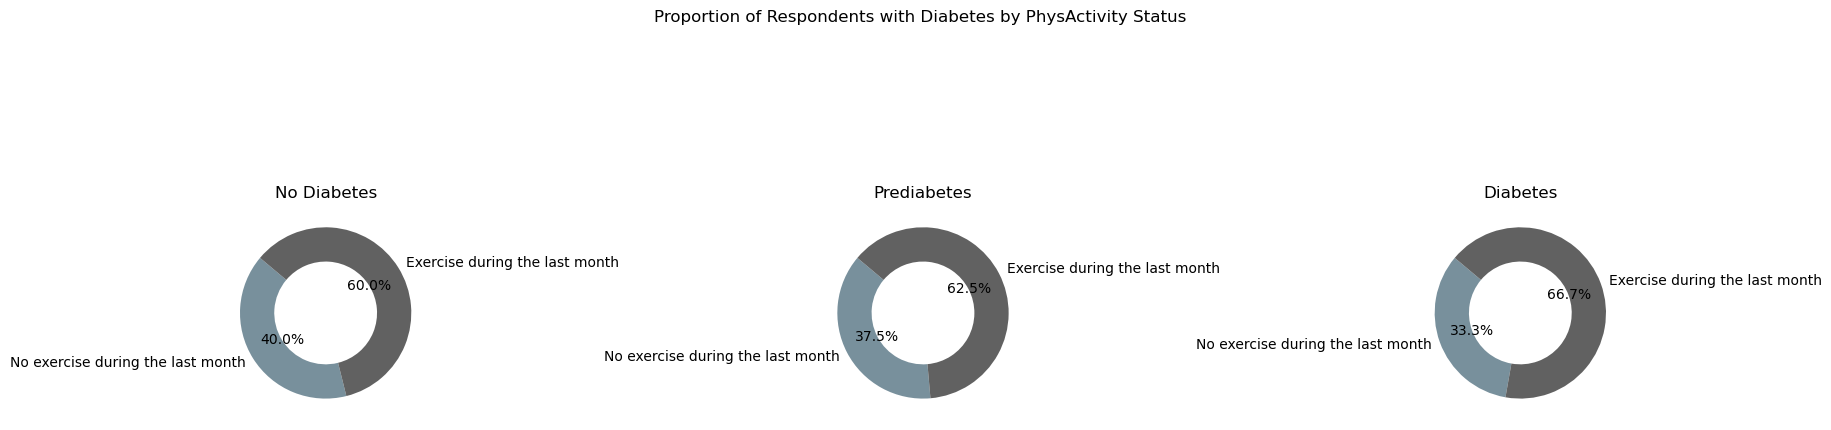

In [55]:
#Doughnut Chart 
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['#78909c','#616161', '#cacaca']
for i, column in enumerate(PhysActivity_pivot_df.columns):
    wedges, texts, autotexts = axes[i].pie(PhysActivity_pivot_df[column], labels=PhysActivity_pivot_df.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4), colors=colors)
    axes[i].set_title(column)

plt.suptitle('Proportion of Respondents with Diabetes by PhysActivity Status')
plt.tight_layout()
plt.show()

## Abigail

## Muad

## Sophia

## Conclusions and Bonus Workspace